In [1]:
!python --version

Python 3.5.3 :: Continuum Analytics, Inc.


In [2]:
!conda env list

# conda environments:
#
astroconda            *  /home/Jerome/miniconda3/envs/astroconda
iraf27                   /home/Jerome/miniconda3/envs/iraf27
ircs_pol                 /home/Jerome/miniconda3/envs/ircs_pol
moscatel                 /home/Jerome/miniconda3/envs/moscatel
py27                     /home/Jerome/miniconda3/envs/py27
root                     /home/Jerome/miniconda3



# Dipper (sub-)list

The links below show the quick look lightcurve reduced using a K2 data pipeline called [K2SFF](https://archive.stsci.edu/prepds/k2sff/) available online.

* [EPIC204514548](https://www.cfa.harvard.edu/~avanderb/k2c2/ep204514548.html)
* [EPIC203384911](https://www.cfa.harvard.edu/~avanderb/k2c2/ep203843911.html)
* [EPIC203937317](https://www.cfa.harvard.edu/~avanderb/k2c2/ep203937317.html)
* [EPIC204630363](https://www.cfa.harvard.edu/~avanderb/k2c2/ep204630363.html)
* [* EPIC204638512](https://www.cfa.harvard.edu/~avanderb/k2c2/ep204638512.html)
* [* EPIC205151387](https://www.cfa.harvard.edu/~avanderb/k2c2/ep205151387.html)
* [EPIC203824153](https://www.cfa.harvard.edu/~avanderb/k2c2/ep203824153.html)
* [* EPIC204278916](https://www.cfa.harvard.edu/~avanderb/k2c2/ep204278916.html)
* [EPIC204469637](https://www.cfa.harvard.edu/~avanderb/k2c2/ep204469637.html)

## Corrected lightcurves from Vanderburg website

* [campaign 2](https://www.cfa.harvard.edu/~avanderb/k2c2/)

The advantage of this approach over using everest-pipeline is that direct download of corrected lightcurve is possible, making analysis relatively quickly. Take caution however that the pipeline might remove inherent variability in the dipper lightcurve so study how the pipeline exactly does the correction. 

In [89]:
epics='''204638512
205151387
204514548
203843911
203937317
204630363
203824153
204278916
204469637'''.split('\n')

In [6]:
import pandas as pd

campaign=str(2)
epic = '204638512'

part1='http://archive.stsci.edu/missions/hlsp/k2sff/c0'
part2='00000/'
part3='/hlsp_k2sff_k2_lightcurve_'
part4='_kepler_v1_llc-default-aper.txt'

url=part1+campaign+'/'+epic[:4]+part2+epic[-5:]+part3+epic+'-c0'+campaign+part4

#
df = pd.read_csv(url, sep=",", header=0, index_col=False)
#set index
df = df.set_index(keys=df.columns[0])
df.head()

,Corrected Flux
BJD - 2454833,
2061.305437,0.722783
2061.325869,0.716395
2061.346302,0.707574
2061.366733,0.701525
2061.387166,0.694175


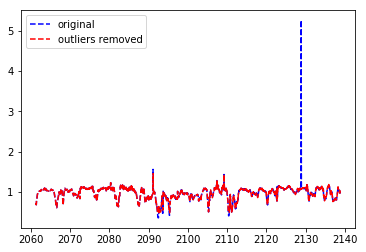

In [12]:
#from astropy.stats import sigma_clip
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline

#remove outliers
df2 = df[(np.abs(stats.zscore(df)) < 3).all(axis=1)]

#plot
plt.plot(df[' Corrected Flux'], 'b--', label='original')
plt.plot(df2[' Corrected Flux'], 'r--', label='outliers removed')
plt.legend()

In [14]:
len(df2.dropna())

3231

In [35]:
#dropna
df2 = df2.dropna()

## Download all

* DF is a dictionary of dataframes
* df is a merged DF

* DF1 has no index while DF2 has the time (BJD) as index
* df2 is a merged DF2

In [90]:
import pandas as pd

campaign=str(2)
part1='http://archive.stsci.edu/missions/hlsp/k2sff/c0'
part2='00000/'
part3='/hlsp_k2sff_k2_lightcurve_'
part4='_kepler_v1_llc-default-aper.txt'


DF = {}
for epic in epics:
    try:
        url=part1+campaign+'/'+epic[:4]+part2+epic[-5:]+part3+epic+'-c0'+campaign+part4
        print('downloading: {}'.format(epic))
        #save in dict
        DF[epic] = pd.read_csv(url, sep=",", header=0, index_col=False)
        #save locally as csv
        #fname=epic+'_lc_vanderburg.csv'
        #DF[epic].to_csv(fname)
    except Exception as e:
        print('{0}: {1}'.format(epic, e))

downloading: 204638512
downloading: 205151387
downloading: 204514548
downloading: 203843911
downloading: 203937317
downloading: 204630363
downloading: 203824153
downloading: 204278916
downloading: 204469637


In [91]:
DF.keys()

dict_keys(['203937317', '204514548', '204469637', '204638512', '204278916', '203843911', '205151387', '204630363', '203824153'])

setting date as index

In [94]:
DF2 = {}
for key in DF.keys():
    DF2[key] = DF[key].set_index(keys=DF[key].columns[0])
    DF2[key].columns = [key]

## Bayesian Regression

[guide](http://scikit-learn.org/stable/modules/linear_model.html#bayesian-regression)

### Bayesian Ridge Regression

Train-Test Split

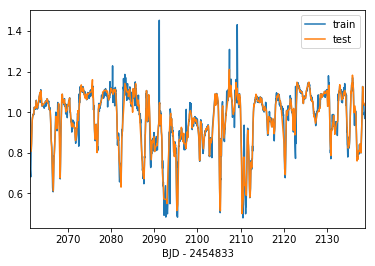

In [36]:
msk = np.random.rand(len(df2)) < 0.8
train = df2[msk]
test = df2[~msk]

fig, ax = plt.subplots(1,1)

train[' Corrected Flux'].plot(ax=ax, label='train')
test[' Corrected Flux'].plot(ax=ax, label='test')
plt.legend()

In [37]:
X_train = train.index.values.reshape(-1,1)
y_train = train[' Corrected Flux'].values

X_test = test.index.values.reshape(-1,1)
y_test = test[' Corrected Flux'].values

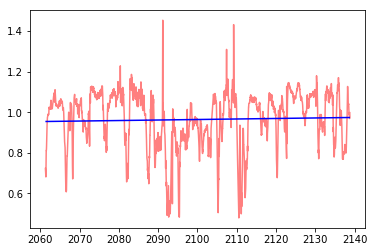

In [38]:
from sklearn import linear_model

reg = linear_model.BayesianRidge(compute_score=True)
reg.fit(X_train,y_train)

br_pred=reg.predict(X_test)

plt.plot(X_train, y_train, 'r-', alpha=0.5)
plt.plot(X_test,br_pred,'b-')

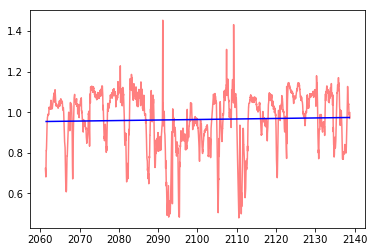

In [39]:
ols = linear_model.LinearRegression()
ols.fit(X_train,y_train)

ols_pred=ols.predict(X_test)

plt.plot(X_train, y_train, 'r-', alpha=0.5)
plt.plot(X_test, ols_pred,'b-')

### Automatic Relevance Determination - ARD

ARDRegression is very similar to Bayesian Ridge Regression, but can lead to sparser weights w. ARDRegression poses a different prior over w, by dropping the assumption of the Gaussian being spherical.

### Logistic Regression (Classification)

In this model, the probabilities describing the possible outcomes of a single trial are modeled using a logistic function.

## Stochastic Gradient Descent - SGD
[doc](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDRegressor.html#sklearn.linear_model.SGDRegressor)

The gradient of the loss is estimated each sample at a time and the model is updated along the way with a decreasing strength schedule (aka learning rate).
SGD is useful when the number of samples (and the number of features) is very large. 

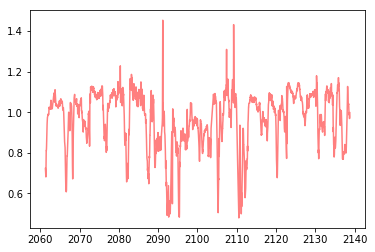

In [40]:
sgd = linear_model.SGDRegressor()
sgd.fit(X_train,y_train)

sgd_pred=sgd.predict(X_test)

plt.plot(X_train, y_train, 'r-', alpha=0.5)
#plt.plot(X_test,sgd_pred,'bo')

## Random Forest

[doc](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor)

A random forest is a meta estimator that fits a number of classifying decision trees on various sub-samples of the dataset and use averaging to improve the predictive accuracy and control over-fitting. The sub-sample size is always the same as the original input sample size but the samples are drawn with replacement if bootstrap=True (default).

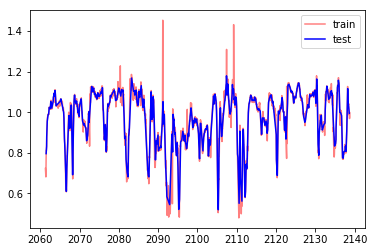

In [41]:
from sklearn import ensemble

rf = ensemble.RandomForestRegressor(random_state=0, n_estimators=100)
rf.fit(X_train,y_train)

rf_pred=rf.predict(X_test)

plt.plot(X_train, y_train, 'r-', alpha=0.5, label='train')
plt.plot(X_test,rf_pred,'b-', label='test')
plt.legend()

## Gaussian Processes

[doc](http://scikit-learn.org/stable/modules/gaussian_process.html)

### Gaussian Process Regression (GPR)

For this, the prior of the GP needs to be specified. The prior mean is assumed to be constant and zero (for normalize_y=False) or the training data’s mean (for normalize_y=True). The prior’s covariance is specified by a passing a kernel object. The hyperparameters of the kernel are optimized during fitting of GaussianProcessRegressor by maximizing the log-marginal-likelihood (LML) based on the passed optimizer. As the LML may have multiple local optima, the optimizer can be started repeatedly by specifying n_restarts_optimizer. The first run is always conducted starting from the initial hyperparameter values of the kernel; subsequent runs are conducted from hyperparameter values that have been chosen randomly from the range of allowed values. If the initial hyperparameters should be kept fixed, None can be passed as optimizer.

The noise level in the targets can be specified by passing it via the parameter alpha, either globally as a scalar or per datapoint. Note that a moderate noise level can also be helpful for dealing with numeric issues during fitting as it is effectively implemented as Tikhonov regularization, i.e., by adding it to the diagonal of the kernel matrix. An alternative to specifying the noise level explicitly is to include a WhiteKernel component into the kernel, which can estimate the global noise level from the data (see example below).

In [73]:
import numpy as np
from sklearn import gaussian_process
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

def f(x):
    return x * np.sin(x)
#features/samples shape in (-1,1): 1 column
X = np.atleast_2d([1., 3., 5., 6., 7., 8.]).T
#labels shape in (1,-1): 1 row
y = f(X).ravel()

# Instanciate a Gaussian Process model
kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))

x = np.atleast_2d(np.linspace(0, 10, 1000)).T
#gp = gaussian_process.GaussianProcess(theta0=1e-2, thetaL=1e-4, thetaU=1e-1)
gp = gaussian_process.GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)

# Fit to data using Maximum Likelihood Estimation of the parameters
gp.fit(X, y)  

GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
             kernel=1**2 * RBF(length_scale=10), n_restarts_optimizer=9,
             normalize_y=False, optimizer='fmin_l_bfgs_b',
             random_state=None)

In [75]:
#y_pred, sigma2_pred = gp.predict(x, eval_MSE=True)

# Make the prediction on the meshed x-axis (ask for MSE as well)
y_pred, sigma = gp.predict(x, return_std=True)

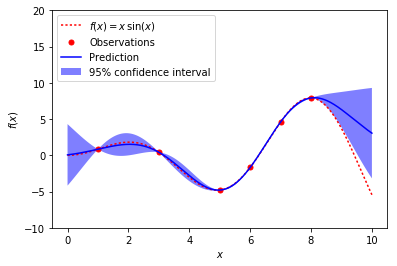

In [76]:
# Plot the function, the prediction and the 95% confidence interval based on
# the MSE
fig = plt.figure()
plt.plot(x, f(x), 'r:', label=u'$f(x) = x\,\sin(x)$')
plt.plot(X, y, 'r.', markersize=10, label=u'Observations')
plt.plot(x, y_pred, 'b-', label=u'Prediction')
plt.fill(np.concatenate([x, x[::-1]]),
         np.concatenate([y_pred - 1.9600 * sigma,
                        (y_pred + 1.9600 * sigma)[::-1]]),
         alpha=.5, fc='b', ec='None', label='95% confidence interval')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.ylim(-10, 20)
plt.legend(loc='upper left')

In [80]:
gp = gaussian_process.GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)

# Fit to data using Maximum Likelihood Estimation of the parameters
gp.fit(X_train[::100],y_train[::100])

gp_pred, sigma=gp.predict(X_test, return_std=True)

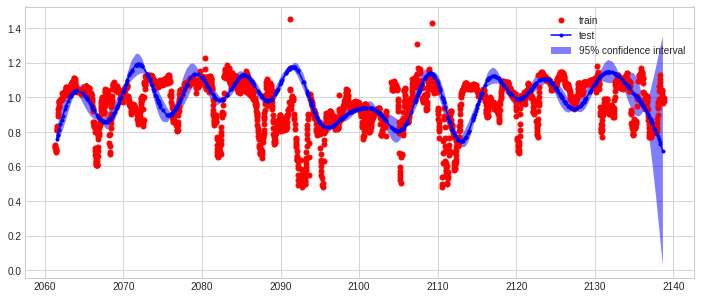

In [87]:
#import seaborn as sns
#sns.set_style("whitegrid")
plt.style.use('seaborn-whitegrid')

fig = plt.figure(figsize=(12,5))
plt.plot(X_train, y_train, 'r.', markersize=10, label=u'train')
plt.plot(X_test, gp_pred, 'b.-', label=u'test')
plt.fill(np.concatenate([X_test, X_test[::-1]]),
         np.concatenate([gp_pred - 1.9600 * sigma,
                        (gp_pred + 1.9600 * sigma)[::-1]]),
         alpha=.5, fc='b', ec='None', label='95% confidence interval')
plt.legend(loc='best')

## Classify if lightcurve is dipper or not

### RF Classifier

[doc](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier)

## Perceptron

## Passive Aggressive Algorithms

## Robustness regression: outliers and modeling errors

## Polynomial regression: extending linear models with basis functions

In [11]:
#ep512=DF[DF.keys()[0]]
ep512=DF[list(DF.keys())[0]]
ep512.head()

,BJD - 2454833,Corrected Flux
0,2061.305415,1.402310
1,2061.325848,1.408289
2,2061.346280,1.420647
3,2061.366712,1.413407
4,2061.387144,1.420006


combine into one dataframe

In [12]:
frames = []
for key in DF.keys():
    frames.append(DF[key])
    
df = pd.concat(frames, axis=1)
df.columns

Index(['BJD - 2454833', ' Corrected Flux', 'BJD - 2454833', ' Corrected Flux',
       'BJD - 2454833', ' Corrected Flux', 'BJD - 2454833', ' Corrected Flux',
       'BJD - 2454833', ' Corrected Flux', 'BJD - 2454833', ' Corrected Flux',
       'BJD - 2454833', ' Corrected Flux', 'BJD - 2454833', ' Corrected Flux',
       'BJD - 2454833', ' Corrected Flux'],
      dtype='object')

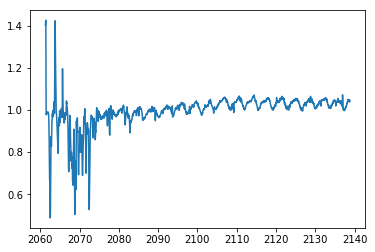

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(ep512[ep512.columns[0]], ep512[ep512.columns[1]])

In [18]:
DF2.keys()

dict_keys(['204278916', '204469637', '204514548', '203843911', '204638512', '203937317', '204630363', '203824153', '205151387'])

In [19]:
frames2 = []
for key in DF2.keys():
    frames2.append(DF2[key])
    
df2 = pd.concat(frames2, axis=1)
df2.columns

Index(['204278916', '204469637', '204514548', '203843911', '204638512',
       '203937317', '204630363', '203824153', '205151387'],
      dtype='object')

In [20]:
for key in df2.columns:
    print('{0}: {1}'.format(key, len(df2[str(key)].dropna())))

204278916: 3302
204469637: 3307
204514548: 3225
203843911: 3241
204638512: 3263
203937317: 3253
204630363: 3246
203824153: 3210
205151387: 3307


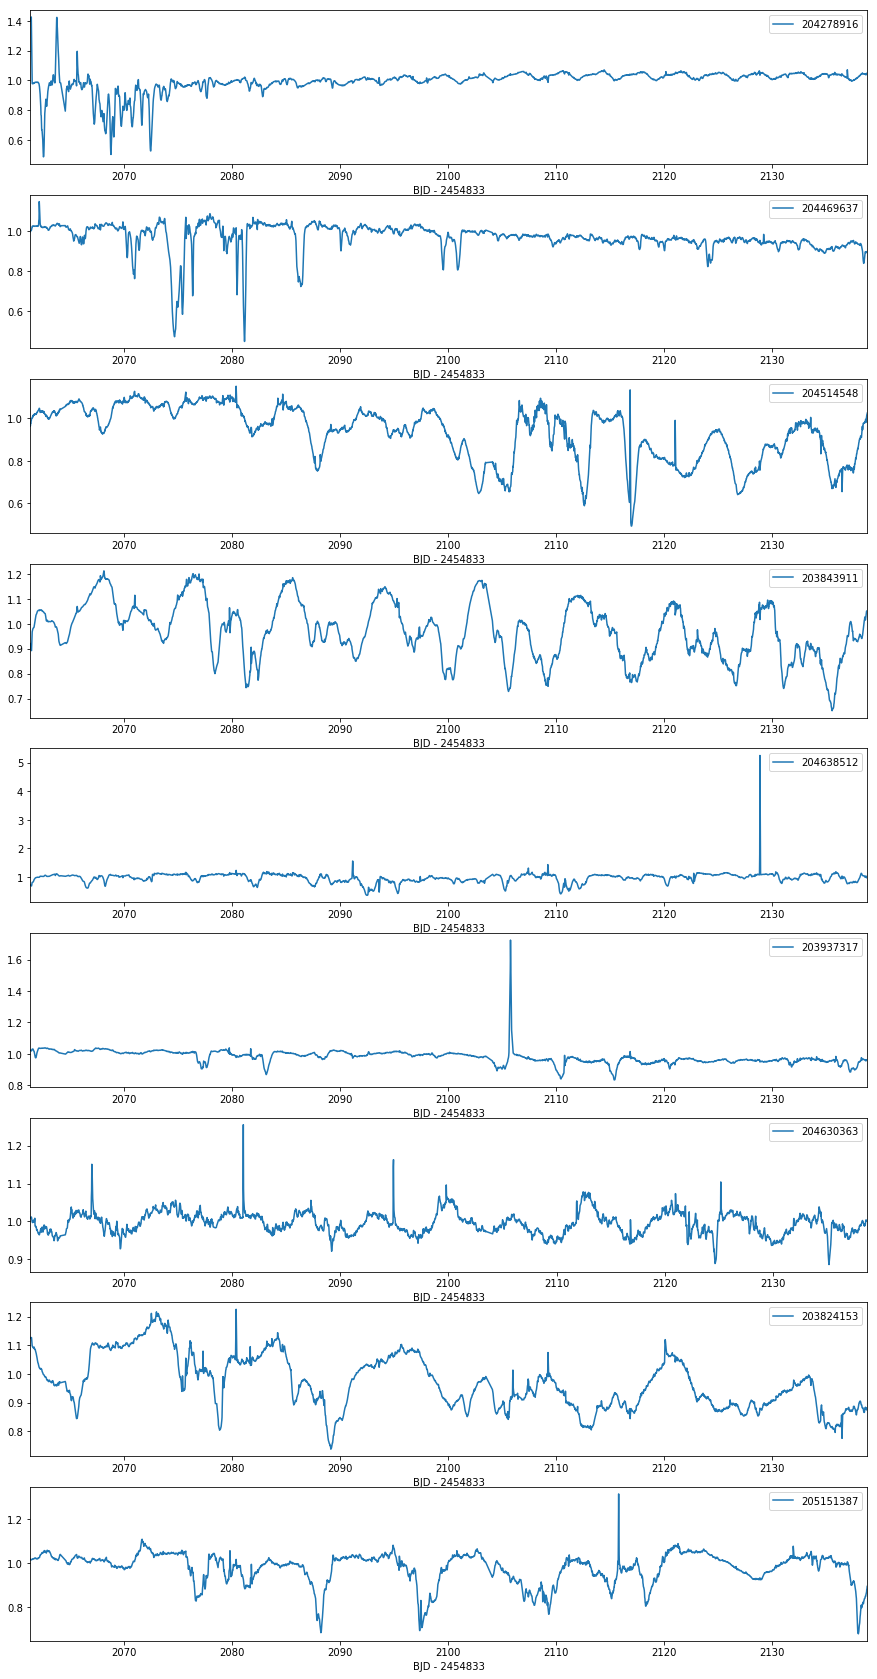

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(nrows=len(df2.columns),ncols=1, figsize=(15,30))
for i,j in enumerate(df2.columns):
    df2[str(j)].dropna().plot(ax=ax[i], legend=True)